In [1]:
import sys
sys.path.append(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project')
from execute_remote_scripts import *
%matplotlib widget
import matplotlib.pyplot as plt
import random
%load_ext autoreload
%autoreload 2
import shutil

from Processing_Data.EDA import *
from Processing_Data.create_labels import * # To load the data in dictionaries

# Enable LaTeX rendering
plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif"
})

C:\Users\Max Tost\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [8]:
# Loading classified shots in dictionaries; time: 2m14
base_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_Files_w_dtIP_conv' # Change this depending on purpose
re_autom_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\automatic_RE_numbers.csv'
re_valid_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\validated_RE_numbers.csv'

dataframes, RE_autom, RE_valid, NO_RE_probably, features = load_and_process_data(
    base_path, re_autom_path, re_valid_path, check_nans_infs
)

# Print results
print(f"Loaded {len(dataframes)} shots.")
print(f"Automatic RE shots: {len(RE_autom)}")
print(f"Validated RE shots: {len(RE_valid)}")
print(f"Probably NO RE shots: {len(NO_RE_probably)}")
print(f"Features: {features}")

DataFrame 100055: 7133 NaNs found. Replacing NaNs with 0.
DataFrame 100057: 6012 NaNs found. Replacing NaNs with 0.
DataFrame 100058: 5778 NaNs found. Replacing NaNs with 0.
DataFrame 100059: 261 NaNs found. Replacing NaNs with 0.
DataFrame 100078: 1926 NaNs found. Replacing NaNs with 0.
DataFrame 100103: 4879 NaNs found. Replacing NaNs with 0.
DataFrame 100110: 5887 NaNs found. Replacing NaNs with 0.
DataFrame 100111: 5899 NaNs found. Replacing NaNs with 0.
DataFrame 100113: 6000 NaNs found. Replacing NaNs with 0.
DataFrame 100126: 4975 NaNs found. Replacing NaNs with 0.
DataFrame 100128: 3355 NaNs found. Replacing NaNs with 0.
DataFrame 100130: 7507 NaNs found. Replacing NaNs with 0.
DataFrame 100131: 1015 NaNs found. Replacing NaNs with 0.
DataFrame 100133: 6283 NaNs found. Replacing NaNs with 0.
DataFrame 100152: 5453 NaNs found. Replacing NaNs with 0.
DataFrame 100165: 6000 NaNs found. Replacing NaNs with 0.
DataFrame 100166: 6000 NaNs found. Replacing NaNs with 0.
DataFrame 10016

In [3]:
random.seed(42) # So that we always work with the same ones.
random_50_re = random.sample(RE_valid, 50)  # Ensures no duplicates

In [91]:
# #In case we need to recreate the dictionary
# RE_lifetimes = {}

# np.savez(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz", **RE_lifetimes)


In [5]:
dataframes[93936]

,SSXcore,time,IPLA,DAO_EDG7,WMHD,DAI_EDG7,ECE_PF,dtIPLA
0,0.066225,53.2662,-2.340677e+06,2.818453e+15,1.373362e+06,2.558226e+16,2.642404,8.673418
1,0.065462,53.2672,-2.340215e+06,2.928634e+15,1.377017e+06,2.830396e+16,2.643238,-8.870374
2,0.066149,53.2682,-2.341622e+06,3.119209e+15,1.378568e+06,3.287544e+16,2.645185,-7.990227
3,0.066301,53.2692,-2.341066e+06,3.067890e+15,1.374046e+06,3.466802e+16,2.647874,12.166975
4,0.066683,53.2702,-2.340326e+06,3.117007e+15,1.370120e+06,3.306676e+16,2.651535,6.572624
...,...,...,...,...,...,...,...,...
5995,0.002136,59.2612,-3.772024e+02,-1.003228e+12,-1.000000e+00,1.848650e+13,0.000000,-3.118605
5996,0.001984,59.2622,-1.456609e+03,-4.901998e+12,-1.000000e+00,1.852758e+13,0.000000,-23.283113
5997,0.002213,59.2632,-3.136819e+03,9.472319e+11,-1.000000e+00,4.079275e+13,0.000000,-10.433918
5998,0.002899,59.2642,-2.693304e+03,-9.393658e+11,-1.000000e+00,3.313622e+13,0.000000,-1.840954


In [11]:
# Turn usetex to true if you want to save the figure
plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif"
})

Stop, you are about to redo work!





















































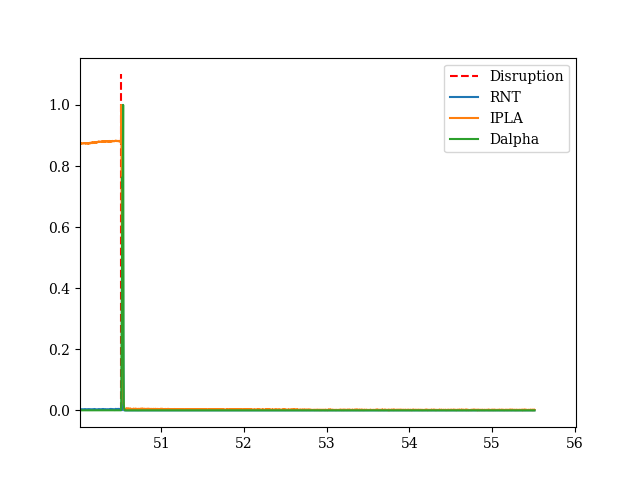

98058


In [15]:
# Shot that is currently processed
k = 3
shot_nr = random_50_re[k]
if str(shot_nr) in list(RE_lifetimes.keys()):
    print('Stop, you are about to redo work!')
    print('\n'*50)

# Load the file and plot it
file_path = os.path.join(base_path, 'JETno' + str(shot_nr)+'.csv')
data = dataframes[shot_nr] # pd.read_csv(file_path)
plt.close()

# Find the first index where time is greater than the starting time + 1
first_index = np.argmax(data['time'] > data['time'][0] + 1)  

# Plot vertical line at this point
plt.vlines(data['time'][first_index], ymin=0, ymax=1.1, color='r', linestyle='dashed', label='Disruption')

#plt.plot(data['time'], data['SSXcore'] /max(data['SSXcore']), label='SSX')
plt.plot(data['time'], data['RNT'] /max(data['RNT']), label='RNT')
plt.plot(data['time'], -data['IPLA'] / max(-data['IPLA']), label='IPLA')
plt.plot(data['time'], -data['DAI_EDG7'] / -max(data['DAI_EDG7']), label='Dalpha')
#plt.plot(data['time'], -data['ECE_PF'] / -max(data['ECE_PF']), label='ECE_PF')

# Show the plot
plt.legend()
plt.xlim(data['time'][first_index]-0.5, data['time'][first_index]+5.5)
plt.show()

print(shot_nr)

In [4]:
# Set time that is to be written as end of the beam time
end_beam = 50.544

# Setting shot number again in case I did something weird in between
#shot_nr = random_50_re[k]

# Load the dictionary
RE_lifetimes = np.load(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz")
RE_lifetimes = {key: RE_lifetimes[key] for key in RE_lifetimes.files}
# Set the new value and save
RE_lifetimes[f'{shot_nr}'] = np.array([data['time'][first_index], end_beam])
np.savez(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz", **RE_lifetimes)

# Plot to verify
plt.close()
plt.vlines(data['time'][first_index], ymin=0, ymax=1.1, color='r', linestyle='dashed', label='Disruption')
plt.vlines(end_beam, ymin=0, ymax=1.1, linestyle='dashed', label='End Beam')
plt.plot(data['time'], -data['IPLA']/max(-data['IPLA']), label='IPLA')
plt.plot(data['time'], -data['RNT'] / -max(data['RNT']), label='RNT')
plt.plot(data['time'], -data['DAI_EDG7'] / -max(data['DAI_EDG7']), label='DAI')
#plt.plot(data['time'], -data['ECE_PF'] / -max(data['ECE_PF']), label='ECE')

# Show the plot
plt.legend()
plt.xlim(data['time'][first_index]-0.02, end_beam+0.05)
plt.title(f'Shot Nr. {shot_nr}')
plt.ylabel('Normalised Observables')
plt.xlabel('Time in s')
#plt.savefig(fr'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\Interesting_Images\RE_Window_{shot_nr}.svg', format='svg')
plt.show()

NameError: name 'data' is not defined

In [5]:
len(RE_lifetimes)

61

## Creating targets from beam durations

In [9]:
save_path_targets = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_targets_w_dtIP_conv'
targets = save_re_targets(RE_lifetimes, base_path, save_path_targets)

# Creating train shots targets without runaways
#NO_RE_train = np.copy(NO_RE_probably)
#random.shuffle(NO_RE_train)
#NO_RE_train = NO_RE_train[:int(len(RE_lifetimes))] # Pick as much random ones as we have targets with runaways
targets_no_re = save_no_re_targets(NO_RE_train, base_path, save_path_targets)

In [10]:
# saving them for training
destination = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Features_w_dtIP_conv'

if not os.path.exists(destination):
    os.mkdir(destination)

for key in RE_lifetimes.keys(): 
    try:
        df = dataframes[int(key)]
        df.to_csv(os.path.join(destination, 'JETno' + str(key) + '.csv'))
    except:
        print(key)
    
for key in NO_RE_train: 
    df = dataframes[int(key)]
    df.to_csv(os.path.join(destination, 'JETno' + str(key) + '.csv'))


True False


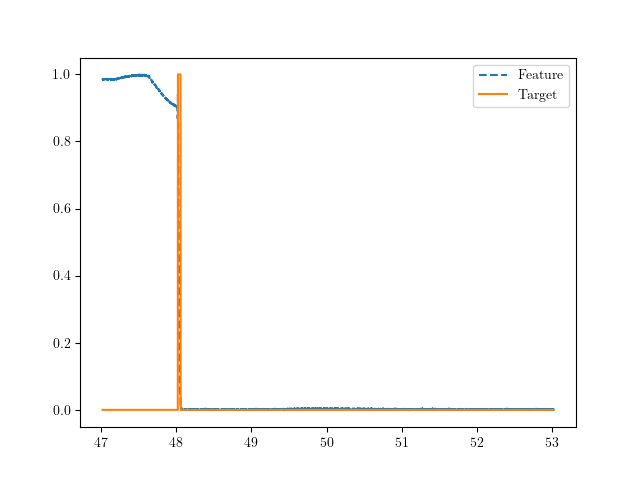

In [ ]:
# Plot random labeled shot for verification
shot_nr = os.listdir(save_path_targets)[random.randint(0, len(os.listdir(save_path_targets)))].split('.')[0].split('no')[1]

# Load the file and plot it
feature_path = os.path.join(base_path, 'JETno' + str(shot_nr)+'.csv')
target_path = os.path.join(save_path_targets, 'JETno' + str(shot_nr)+'.csv')
feature = pd.read_csv(feature_path)
target = pd.read_csv(target_path)

plt.close()
plt.plot(feature['time'], -feature['IPLA'] /max (-feature['IPLA']), '--', label='Feature')
plt.plot(feature['time'], target['target'], label='Target')
plt.legend()
print(int(shot_nr) in RE_valid, int(shot_nr) in NO_RE_probably)